# 🔍 Explaining Credit Risk Predictions with SHAP

In this notebook, I focus on **interpreting predictions** made by our final LightGBM model using **SHAP (SHapley Additive exPlanations)**.

Understanding *why* a model makes certain predictions is essential in credit risk scoring, where decisions must be explainable, auditable, and fair — especially when they affect access to financial services.

### 🎯 Objectives

- Load the final trained LightGBM model and validation dataset  
- Use SHAP to **identify key drivers of loan default risk**  
- Generate **global explanations** (what influences predictions overall)  
- Generate **local explanations** (why this specific applicant was flagged)  
- Support **transparent, actionable insights** for real-world credit scoring

### 📁 Inputs

- `lgbm_model.joblib`: Final tuned model with threshold adjustments  
- `X_valid.parquet`: Validation set used for model evaluation  
- `y_valid.parquet`: Ground truth labels for the validation set

By the end of this notebook, I’ll have a **transparent interpretation** of the model’s behavior — both at the **dataset level** and for **individual loan applicants**.

---
### 📦 Load Required Libraries

I begin by importing essential libraries for loading the saved model, reading input files, and suppressing warnings to keep the notebook output clean.

In [1]:
# For saving and loading trained model files
import joblib

# For loading and manipulating datasets
import pandas as pd

# For suppressing warning messages in notebook output
import warnings

# For model interpretability using SHAP values
import shap

# For creating plots and visualizations
import matplotlib.pyplot as plt

### 📁 Load Saved Model and Validation Data

I now load the final trained LightGBM model along with the validation dataset and labels saved in the previous notebook. These will be used for local and global interpretability using SHAP.

In [2]:
# Load the final trained LightGBM model
model = joblib.load("../models/lgbm_model.joblib")

# Load the validation feature set
X_valid = pd.read_parquet("../data/processed/X_valid.parquet")

# Load the corresponding validation labels
y_valid = pd.read_parquet("../data/processed/y_valid.parquet").squeeze()

### 🧠 Generate SHAP Beeswarm Plot

I now create a SHAP beeswarm plot to interpret the LightGBM model's predictions on the validation set. This plot shows how each feature contributes to the prediction for each instance. It helps reveal:

- Which features are most impactful globally  
- Whether high or low feature values push predictions toward default or non-default  
- The range and distribution of SHAP values across the sample  

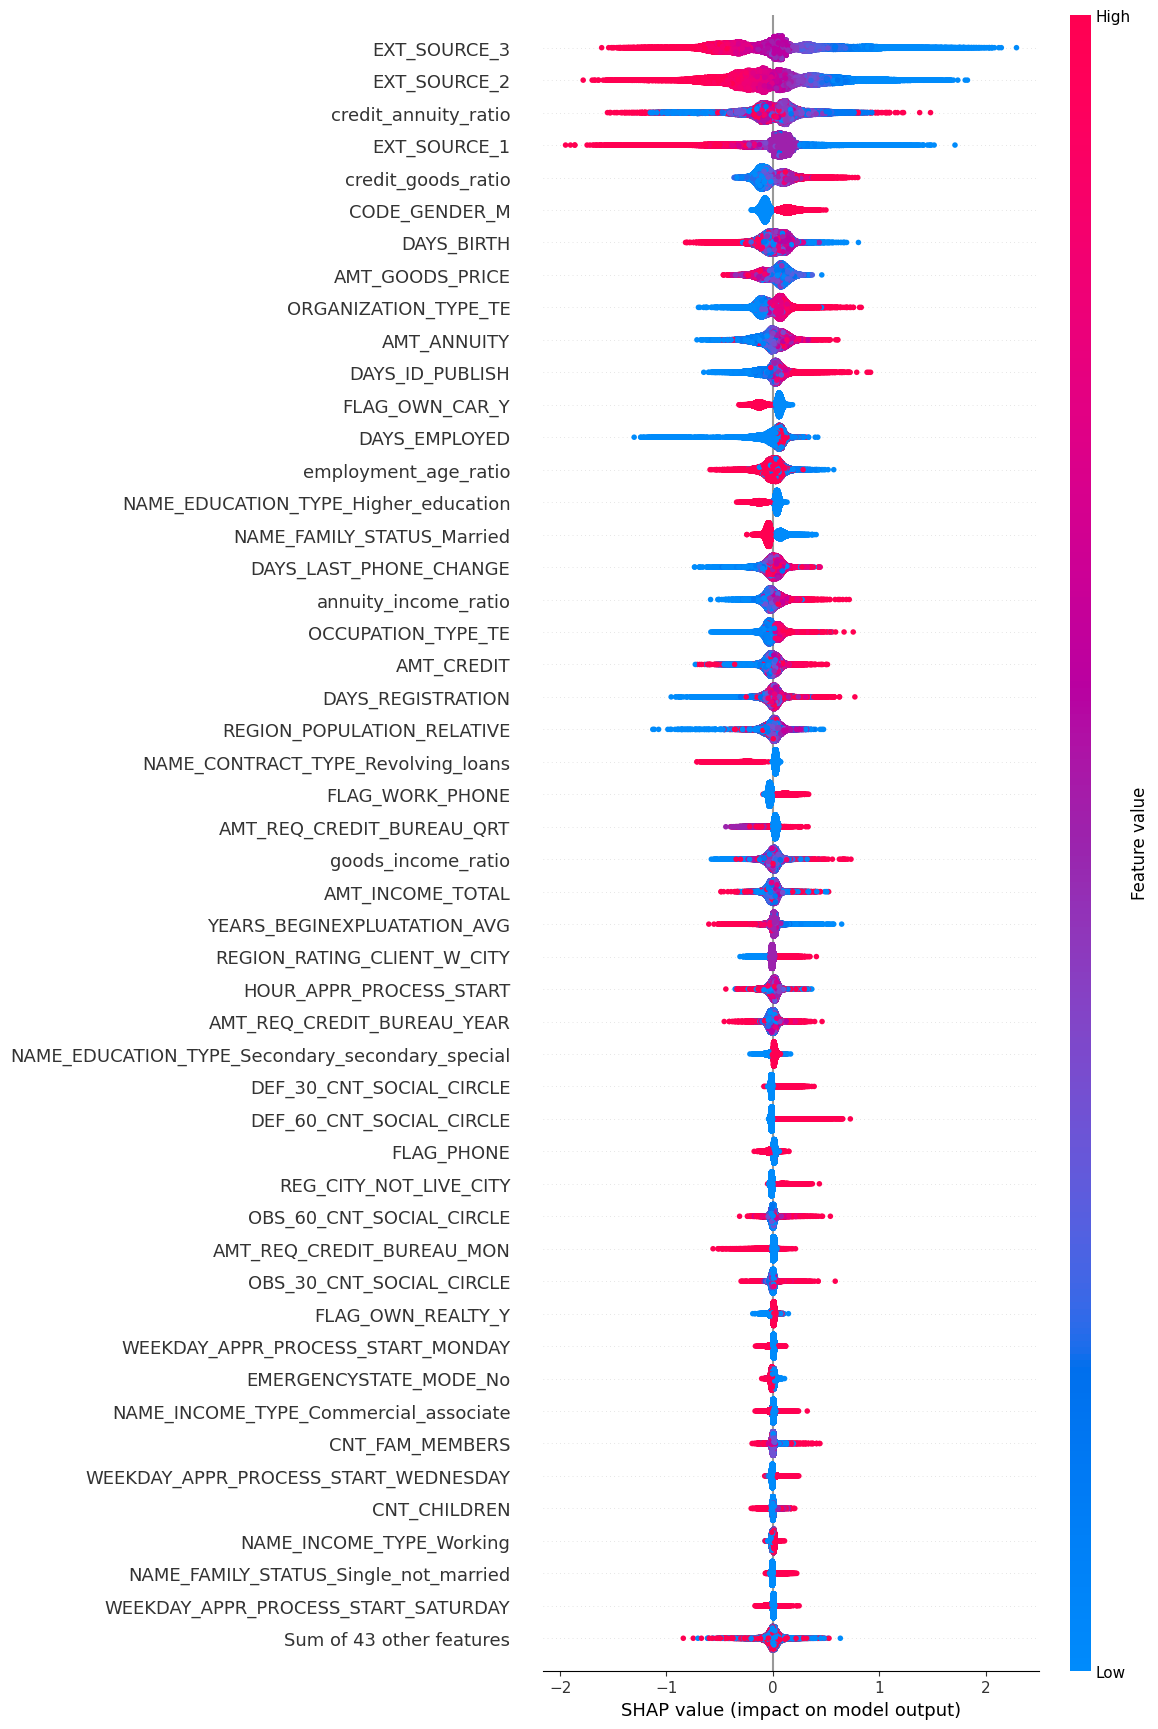

In [3]:
# Initialize SHAP explainer (auto-selects TreeExplainer for LightGBM)
explainer = shap.Explainer(model)

# Compute SHAP values for the validation feature set
shap_values = explainer(X_valid)

# Generate SHAP beeswarm plot to show global feature impact
shap.plots.beeswarm(shap_values, max_display=50)

### 🐝 SHAP Beeswarm Summary: Understanding Global Feature Impact

The SHAP beeswarm plot above reveals the **top features** driving the LightGBM model's predictions across the validation set. Each dot represents a SHAP value for a single prediction, showing both the **magnitude** and **direction** of a feature’s impact.

#### Key Observations:
- **`EXT_SOURCE_3`, `EXT_SOURCE_2`, and `EXT_SOURCE_1`** are by far the most influential predictors, suggesting that external credit scores are strong signals of default risk.
- Our **engineered ratio features** (e.g., `credit_annuity_ratio`, `credit_goods_ratio`, `employment_age_ratio`) appear prominently in the top 10, validating the usefulness of domain-informed feature engineering.
- **Demographic indicators** such as `CODE_GENDER_M`, `DAYS_BIRTH`, and `NAME_EDUCATION_TYPE_Higher_education` also influence predictions, though to a lesser degree.

The **color gradient** (red = high feature value, blue = low feature value) shows how feature magnitude correlates with risk. For example:
- Higher `EXT_SOURCE` values are associated with **lower SHAP values**, reducing the model's prediction of default.
- Higher `credit_annuity_ratio` values (larger loan relative to annuity) increase default risk, reflected in **positive SHAP contributions**.

> This global interpretability confirms that the model is leveraging **financially meaningful, risk-aligned variables**, combining external scores with behavior-driven and engineered indicators to inform predictions.

---
### 📍 Local Explanations with SHAP: Waterfall Plots for Individual Applicants

While the SHAP summary plot helps us understand **global feature impact**, it’s just as important to interpret **individual predictions**—especially in a domain like credit risk.

In this section, I select three representative applicants:
- A **likely non-defaulter**
- A **likely defaulter**
- A **borderline case** (predicted probability near the midpoint)

For each applicant, I generate a **SHAP waterfall plot** to visualize how individual features push the model's prediction higher or lower. This breakdown helps us clearly see which features contribute most to each decision—offering transparency for case-by-case risk assessments.


 Low Risk (Likely to Repay)


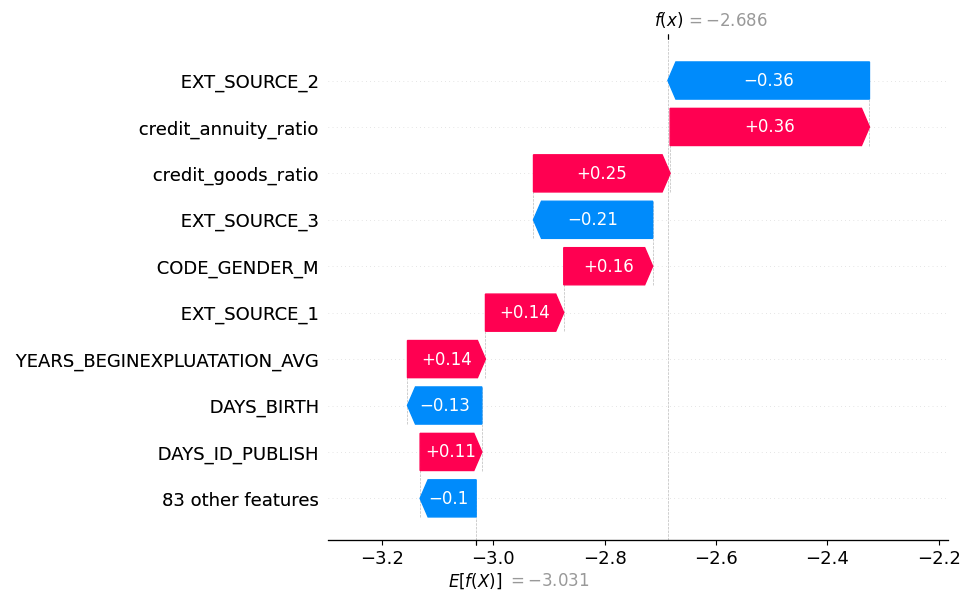


 High Risk (Likely to Default)


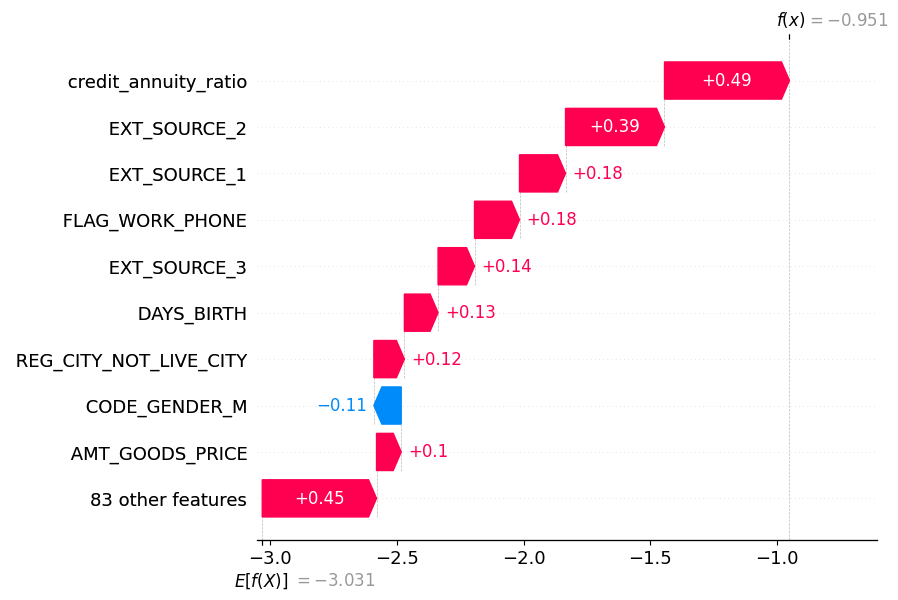


 Borderline Case


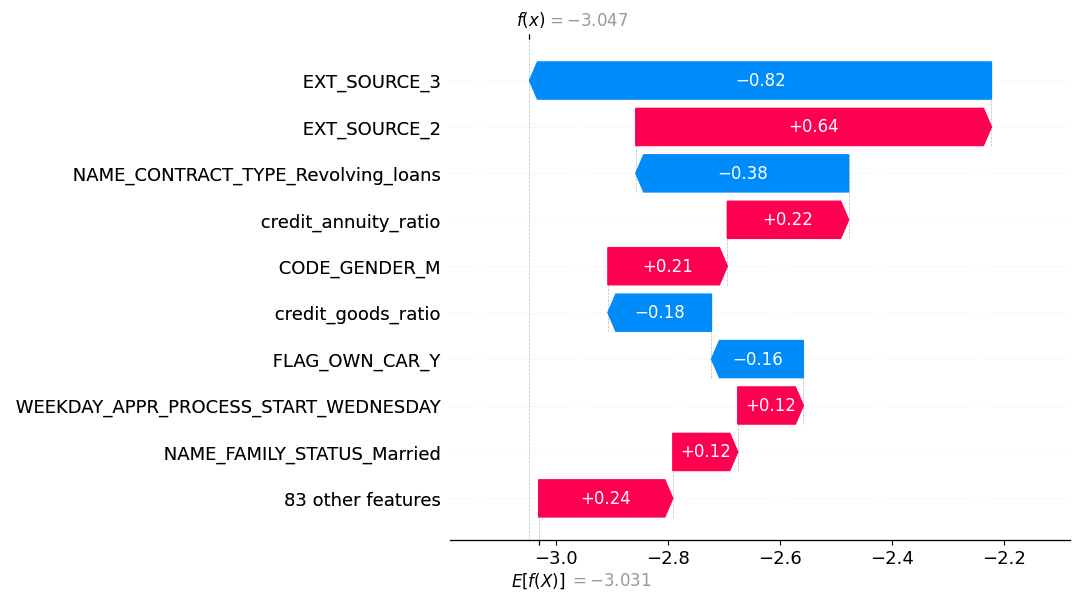

In [4]:
# Predict probability of default for each applicant in validation set
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# Suppress known SHAP warning about list output for LightGBM
warnings.filterwarnings(
    "ignore",
    message="LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray"
)

# Select three representative applicants for local explanation
applicants = {
    "Low Risk (Likely to Repay)": X_valid[y_valid == 0].sample(1, random_state=1),
    "High Risk (Likely to Default)": X_valid[y_valid == 1].sample(1, random_state=1),
    "Borderline Case": X_valid.iloc[[y_pred_proba.argsort()[::-1][len(y_valid) // 2]]]
}

# Generate SHAP waterfall plots to explain individual predictions
for label, applicant in applicants.items():
    shap_values_single = explainer.shap_values(applicant)

    # Handle SHAP output format (LightGBM returns list with [0]=non-default, [1]=default)
    if isinstance(shap_values_single, list):
        shap_val = shap_values_single[1][0]
        expected_val = explainer.expected_value[1]
    else:
        shap_val = shap_values_single[0]
        expected_val = explainer.expected_value

    # Display plot with individual feature contributions
    print(f"\n {label}")
    shap.plots._waterfall.waterfall_legacy(
        shap_values=shap_val,
        expected_value=expected_val,
        features=applicant.iloc[0],
        feature_names=applicant.columns
    )

### 🔎 Individual-Level Insights: SHAP Waterfall Explanations

To complement the global beeswarm plot, I generated **SHAP waterfall plots** for three representative applicants:

1. **Low Risk (Likely to Repay)**  
   This applicant’s predicted probability of default is low, driven by **high external credit scores** (`EXT_SOURCE_2`, `EXT_SOURCE_3`) and favorable **credit-to-income ratios** (`credit_annuity_ratio`, `credit_goods_ratio`). These features contribute negative SHAP values, pulling the model’s prediction sharply toward **non-default**.  
   Notably, factors like a **recent employment history** (`YEARS_BEGINEXPLUATATION_AVG`) and fewer red-flag signals (e.g., clean `DAYS_ID_PUBLISH`) also reduce perceived risk.

2. **High Risk (Likely to Default)**  
   This applicant is predicted to default, primarily due to a **high `credit_annuity_ratio`**, indicating they have **a large loan relative to their annuity** — a potential sign of repayment stress.  
   While they possess moderate external scores (`EXT_SOURCE_2`, `EXT_SOURCE_1`), these are not strong enough to offset risk factors like the presence of a **work phone flag** (`FLAG_WORK_PHONE`) and living in a different city than registered (`REG_CITY_NOT_LIVE_CITY`).  
   In combination, these signals suggest financial **instability or inconsistency**, prompting the model to lean toward **default**.

3. **Borderline Case**  
   This applicant falls close to the model’s decision threshold. Their SHAP plot shows a **balanced push** from both risk-reducing and risk-increasing features.  
   For example, `EXT_SOURCE_3` contributes a strong negative value (reducing default risk), while `EXT_SOURCE_2`, a **contract type for revolving loans**, and `credit_annuity_ratio` nudge the prediction higher.  
   This interplay illustrates how **small shifts in a few variables** could tip the outcome — a reality in many real-world credit approval processes.

> These local explanations support **transparent, auditable, and context-aware lending decisions** — ensuring that model predictions can be trusted and acted upon in high-stakes environments.

---
✅ **Notebook Summary**

In this notebook, I enhanced model transparency by interpreting LightGBM predictions with SHAP. The combination of global and local explanations reinforces the model's alignment with real-world lending practices — where fairness, traceability, and actionable insights are key.

This completes the interpretability phase of the project.